In [30]:
import matplotlib.pyplot as plt
import pydicom
import os
import cv2
import numpy as np

np.set_printoptions(threshold=np.inf)

In [31]:
path = "./XRAY TEST/xray"
files = os.listdir(path)

In [32]:
ds = []
#pixl_array包含了真实数据

for file in files:
    if not os.path.isdir(file):
        f = path+"/"+file
        data = pydicom.read_file(f)
        ds.append(data.pixel_array)

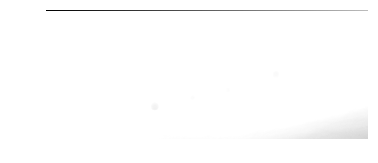

In [33]:
origin = ds[2]

#crop = origin[0:250, 150:800]
crop_1 = np.zeros((250,650), dtype = origin.dtype )
crop_2 = np.zeros((250,650), dtype = origin.dtype )

for i in range(0, 250):
    for j in range(150, 800):
        k = i
        t = j-150
        if origin[i][j] < 700:
            crop_1[k][t] = 4094 #对黑色边角的处理，直接设置最亮
        else:
            crop_1[k][t] = origin[i][j]

crop_2[:, :] = crop_1[:, :]
plt.imshow(crop_1,cmap="gray")
plt.axis("off")
plt.show()
#arr_a = crop_2.flatten()
#n, bins, patches = plt.hist(arr_a, bins=256, normed=1, facecolor='blue', alpha=0.75)  
#plt.show()

In [34]:
## Retinex 算法

## single scale retinex
def ssr(img, sigma):
    temp = cv2.GaussianBlur(img, (0,0), sigma)
    gaussian = np.where(temp==0, 0.01, temp)
    img_ssr = np.log10(img+0.01) - np.log10(gaussian)
    
    return img_ssr

In [35]:
def msrcr(img, sigma,dynamic):
    img_msrcr = np.zeros_like(img*1.0)
    img = ssr(img,sigma)
    ## log[R(x,y)]
    
    img_arr = img
    mean = np.mean(img_arr)
    sum1 = img_arr.sum()
    img_arr2 = img_arr * img_arr
    sum2 = img_arr2.sum()
    var_squ = sum2 - 2*mean*sum1 + 1024*1024*mean*mean
    var = np.sqrt(var_squ)
    
    Min = mean - dynamic*var
    Max = mean + dynamic*var

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_msrcr[i][j] = (img[i][j] - Min) / \
                                        (Max-Min)*255
            ## 溢出判断
            if img_msrcr[i][j] > 255:
                img_msrcr[i][j] = 255
            if img_msrcr[i][j] < 0:
                img_msrcr[i][j] = 0
    
    return img_msrcr

In [36]:
## http://www.cnblogs.com/zmshy2128/p/6126987.html
## 链接里提到，Retinex对于比较亮的图处理的不是很好
## 所以先做一个反色的处理

crop_rev = np.zeros((250,650), dtype = origin.dtype )
for i in range(0, crop_2.shape[0]):
    for j in range(0, crop_2.shape[1]):
        crop_rev[i][j] = 4094 - crop_2[i][j]

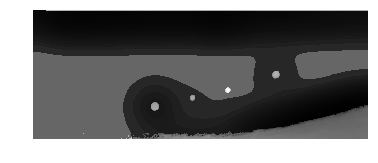

In [37]:
sigma = 30
## 指定尺度（模糊的半径）
dy = 2
#Dynamic取值越小，图像的对比度越强。
#一般来说Dynamic取值2-3之间能取得较为明显的增强效果

#retinex_ssr = ssr(crop_rev, sigma)
retinex_msrcr = msrcr(crop_rev, sigma,dy)

cv2.normalize(retinex_msrcr,retinex_msrcr, 0, 255, cv2.NORM_MINMAX)
img_c= cv2.convertScaleAbs(retinex_msrcr)

fgamma = 1.4
img_cc = np.power((img_c/255.0),fgamma)*255.0

plt.imshow(img_cc, cmap="gray")
plt.axis("off")
plt.show()
## Gamma矫正减少一点光晕

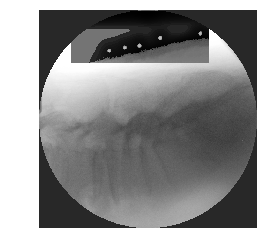

In [28]:
tmp_1 =  np.zeros((origin.shape[0],origin.shape[1]), dtype = origin.dtype )
tmp_1[:, :] = origin[:, :]

cv2.normalize(tmp_1,tmp_1, 0, 255, cv2.NORM_MINMAX)
tmp= cv2.convertScaleAbs(tmp_1)


for i in range(0, 250):
    for j in range(0, 650):
        t = j+150
        if origin[i][t] >= 700:
            tmp_1[i][t] = img_cc[i][j]

plt.imshow(tmp_1, cmap="gray")
plt.axis("off")
plt.show()

In [29]:
print(img_cc.shape)

(250, 650)
